#Imports

In [84]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatplotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

## Models
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

## Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay, r2_score, mean_absolute_error, mean_squared_error

from sklearn import metrics

from sklearn.model_selection import GridSearchCV

## Import SMOTE
from imblearn.over_sampling import SMOTE
## Import special pipeline for smote
from imblearn.pipeline import make_pipeline as smote_pipe


## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

Upload Data from FIFA 22 

In [11]:
#Upload FIFA 22 data

df = pd.read_csv('C:\\Users\\bandj\\Desktop\\Class assignments\\FifaPlayers22.csv')

Explore and Clean Data

In [12]:
df.head()

,overall,potential,value_eur,age,height_cm,weight_kg,club_team_id,league_level,club_position,work_rate,...,defending,attacking_finishing,skill_dribbling,skill_curve,movement_acceleration,movement_sprint_speed,power_shot_power,power_long_shots,mentality_aggression,defending_marking_awareness
0,93,93,78000000.0,34,170,72,73.0,1.0,RW,Medium/Low,...,34.0,95,96,93,91,80,86,94,44,20
1,92,92,119500000.0,32,185,81,21.0,1.0,ST,High/Medium,...,44.0,95,85,79,77,79,90,87,81,35
2,91,91,45000000.0,36,187,83,11.0,1.0,ST,High/Low,...,34.0,95,88,81,85,88,94,93,63,24
3,91,91,129000000.0,29,175,68,73.0,1.0,LW,High/Medium,...,37.0,83,95,88,93,89,80,81,63,35
4,91,91,125500000.0,30,181,70,10.0,1.0,RCM,High/High,...,64.0,82,88,85,76,76,91,91,76,68


In [13]:
#Make a copy of data in case of errors
ml_df = df.copy()

In [14]:
#Look for duplicates
df.duplicated().sum()

0

In [15]:
#Drop unecessary columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overall                      19239 non-null  int64  
 1   potential                    19239 non-null  int64  
 2   value_eur                    19165 non-null  float64
 3   age                          19239 non-null  int64  
 4   height_cm                    19239 non-null  int64  
 5   weight_kg                    19239 non-null  int64  
 6   club_team_id                 19178 non-null  float64
 7   league_level                 19178 non-null  float64
 8   club_position                19178 non-null  object 
 9   work_rate                    19239 non-null  object 
 10  body_type                    19239 non-null  object 
 11  pace                         17107 non-null  float64
 12  shooting                     17107 non-null  float64
 13  passing         

In [16]:

#Drop club_team_id and league_level, since these are not player attributes or stats, and 
#likely don't affect salary
df.drop(columns='club_team_id', inplace=True)

In [17]:
df.drop(columns='league_level', inplace=True)

In [19]:
df.isna().sum()

overall                           0
potential                         0
value_eur                        74
age                               0
height_cm                         0
weight_kg                         0
club_position                    61
work_rate                         0
body_type                         0
pace                           2132
shooting                       2132
passing                        2132
dribbling                      2132
defending                      2132
attacking_finishing               0
skill_dribbling                   0
skill_curve                       0
movement_acceleration             0
movement_sprint_speed             0
power_shot_power                  0
power_long_shots                  0
mentality_aggression              0
defending_marking_awareness       0
dtype: int64

Drop rows with NA values 

In [20]:
df.dropna(axis=0, inplace=True)
df.isna().sum()

overall                        0
potential                      0
value_eur                      0
age                            0
height_cm                      0
weight_kg                      0
club_position                  0
work_rate                      0
body_type                      0
pace                           0
shooting                       0
passing                        0
dribbling                      0
defending                      0
attacking_finishing            0
skill_dribbling                0
skill_curve                    0
movement_acceleration          0
movement_sprint_speed          0
power_shot_power               0
power_long_shots               0
mentality_aggression           0
defending_marking_awareness    0
dtype: int64

For club position, I'm going to use "constant", instead of most_freq, because club position is unique, and salary changes drastically depending on position. I don't want a position that pays low (like wing defender), to be imputed as a position that pays high
(like attacker), since that would skew my data.

For all other missing data - those are statistics, so Im'going to use mean, since that won't likely skew data.

In [136]:
#Look for outliers
df.describe(include='all')

,overall,potential,value_eur,age,height_cm,weight_kg,club_position,work_rate,body_type,pace,...,defending,attacking_finishing,skill_dribbling,skill_curve,movement_acceleration,movement_sprint_speed,power_shot_power,power_long_shots,mentality_aggression,defending_marking_awareness
count,17041.000000,17041.000000,1.704100e+04,17041.000000,17041.000000,17041.000000,17041,17041,17041,17041.000000,...,17041.000000,17041.000000,17041.000000,17041.000000,17041.000000,17041.000000,17041.000000,17041.000000,17041.000000,17041.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,28,9,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,SUB,Medium/Medium,Normal (170-185),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,7355,7867,6365,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,65.930286,71.243061,2.965082e+06,25.065959,180.389179,74.089314,NaN,NaN,NaN,68.235491,...,51.691098,50.237838,60.950472,51.347221,68.204976,68.238836,59.169298,51.011736,59.249281,50.699137
std,6.773755,6.048461,7.717024e+06,4.605071,6.545547,6.696454,NaN,NaN,NaN,10.905376,...,16.185957,16.244542,11.892807,14.749179,11.394183,11.198366,13.190405,15.723050,13.846605,17.369045
min,47.000000,49.000000,1.500000e+04,16.000000,155.000000,49.000000,NaN,NaN,NaN,28.000000,...,14.000000,10.000000,16.000000,12.000000,27.000000,27.000000,20.000000,11.000000,20.000000,10.000000
25%,62.000000,67.000000,5.250000e+05,21.000000,176.000000,70.000000,NaN,NaN,NaN,62.000000,...,37.000000,37.000000,55.000000,40.000000,62.000000,62.000000,51.000000,39.000000,50.000000,37.000000
50%,66.000000,71.000000,1.000000e+06,25.000000,180.000000,74.000000,NaN,NaN,NaN,69.000000,...,56.000000,53.000000,63.000000,52.000000,69.000000,69.000000,61.000000,54.000000,60.000000,55.000000
75%,70.000000,75.000000,2.100000e+06,28.000000,185.000000,78.000000,NaN,NaN,NaN,76.000000,...,64.000000,63.000000,69.000000,63.000000,76.000000,76.000000,69.000000,63.000000,69.000000,64.000000


In [22]:
#There don't seem to be any outliers.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17041 entries, 0 to 19238
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overall                      17041 non-null  int64  
 1   potential                    17041 non-null  int64  
 2   value_eur                    17041 non-null  float64
 3   age                          17041 non-null  int64  
 4   height_cm                    17041 non-null  int64  
 5   weight_kg                    17041 non-null  int64  
 6   club_position                17041 non-null  object 
 7   work_rate                    17041 non-null  object 
 8   body_type                    17041 non-null  object 
 9   pace                         17041 non-null  float64
 10  shooting                     17041 non-null  float64
 11  passing                      17041 non-null  float64
 12  dribbling                    17041 non-null  float64
 13  defending       

In [24]:
#Inspect for inconsistent values
print(df['age'].value_counts())
print(df['club_position'].value_counts())
print(df['work_rate'].value_counts())
print(df['body_type'].value_counts())


21    1397
22    1306
24    1287
25    1261
23    1251
20    1225
26    1081
27    1080
29    1071
28    1005
19     984
30     794
31     720
18     660
32     545
33     394
34     287
17     240
35     199
36     110
37      69
38      33
39      23
16      19
Name: age, dtype: int64
SUB    7355
RES    2681
RCB     701
LCB     700
LB      515
RB      515
ST      475
RCM     470
LCM     469
LM      410
RM      410
CAM     292
RDM     223
LDM     223
RS      223
LS      222
CB      185
RW      185
LW      185
CDM     168
RWB     116
LWB     116
CM       83
RF       35
LF       35
LAM      21
RAM      21
CF        7
Name: club_position, dtype: int64
Medium/Medium    7867
High/Medium      3651
Medium/High      1867
High/High        1092
High/Low          806
Medium/Low        800
Low/Medium        462
Low/High          453
Low/Low            43
Name: work_rate, dtype: int64
Normal (170-185)    6365
Lean (170-185)      3996
Normal (185+)       2976
Lean (185+)         1540
Normal (170-) 

In [25]:
#There aren't any inconsistencies in my object data

Create univariate visuals for featuers and target

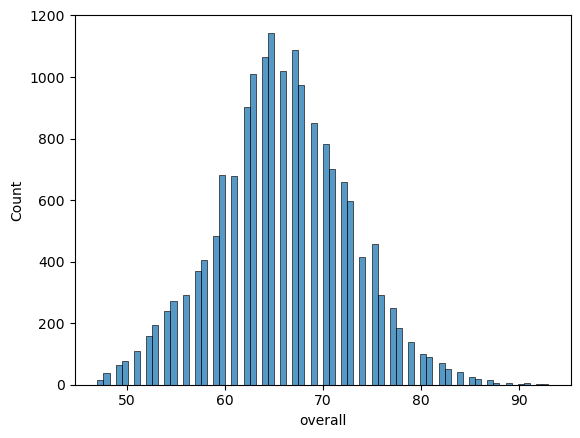

In [27]:
#Overall- create histogram
sns.histplot(data=df, x='overall');

The majority of the overall ratings of players is about 66.

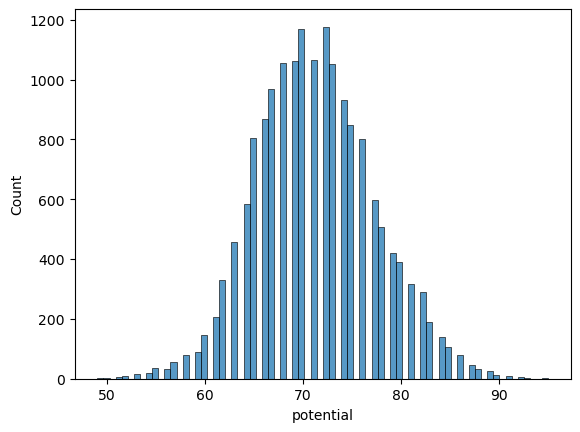

In [28]:
#Histogram for potential
sns.histplot(data=df, x='potential');

The potential of player talent lies mostly between 70-75. This is higher than the average of actual player talent, meaning that clubs tend to over-value players based on potential versus actual ability.

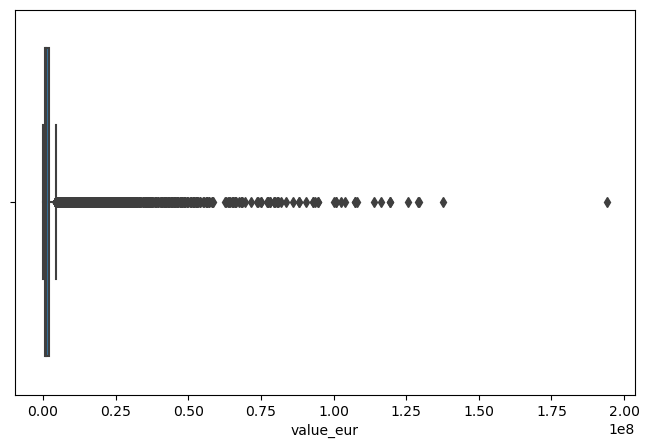

In [29]:
#Value in Euros - Target column
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
sns.boxplot(data=df, x='value_eur');

The majority of players earn in the 25th quartile of all salaries. There is one outlier player who earns 25% more than the rest of players. 

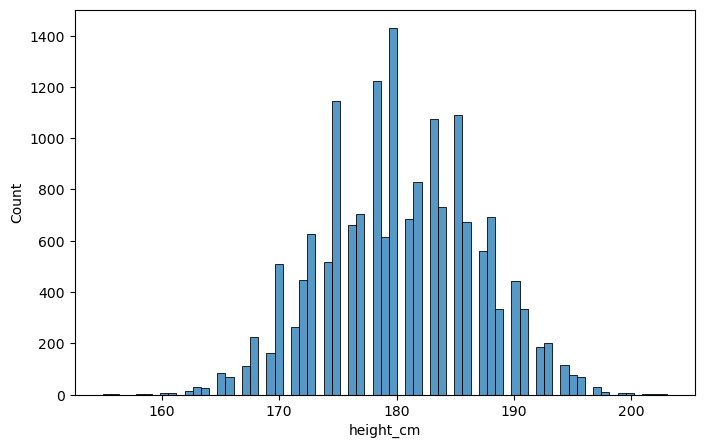

In [137]:
fig, axes = plt.subplots(figsize=(8,5))
sns.histplot(data=df, x='height_cm');

Most players are 180 centimeters tall, or about 6ft.

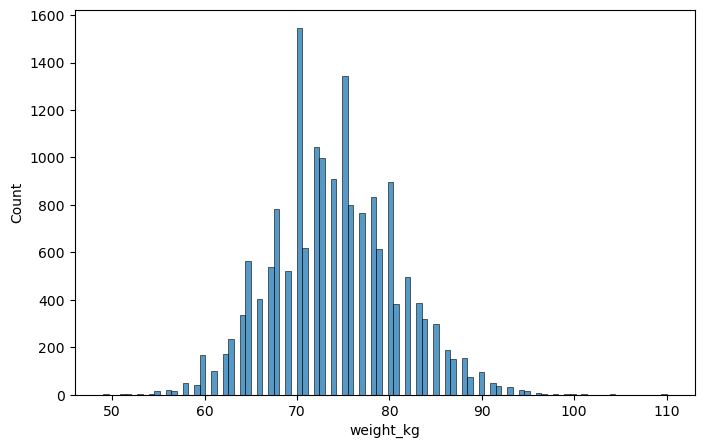

In [138]:
fig, axes = plt.subplots(figsize=(8,5))
sns.histplot(data=df, x='weight_kg');

Most players weigh between 70-75 kilograms, or between 160-165 pounds.

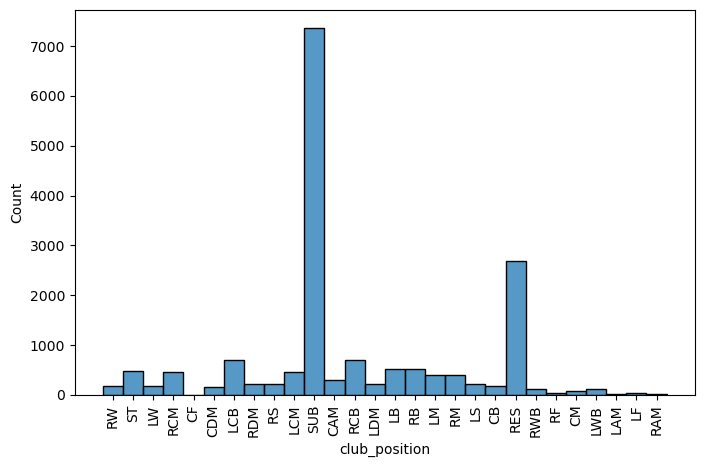

In [139]:
fig, axes = plt.subplots(figsize=(8,5))
plt.xticks(rotation='vertical')
sns.histplot(data=df, x='club_position');

The majority of players are substitutes, the second highest position is reserve players.

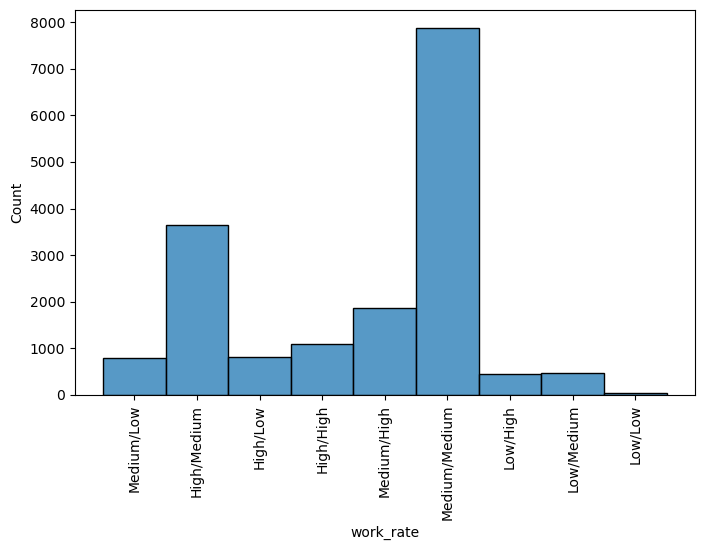

In [140]:
#Work rate
fig, axes = plt.subplots(figsize=(8,5))
plt.xticks(rotation='vertical')
sns.histplot(data=df, x='work_rate');

Most players' work rate is rated as "medium / medium".  

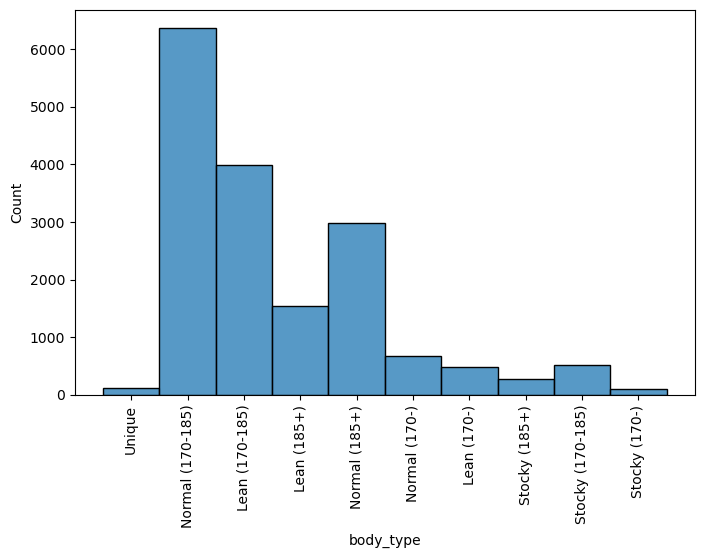

In [34]:
#Body Types
fig, axes = plt.subplots(figsize=(8,5))
plt.xticks(rotation='vertical')
sns.histplot(data=df, x='body_type');

Most body types are normal. The fewest body types are stocky. 

Multivariate Exploration

Questions: 
1) What age players earn the most?
2) How much do established player make compared to younger, raw talent with high "potential." 
3) Out of shooting, passing, dribbling, and defending, which is valued more?

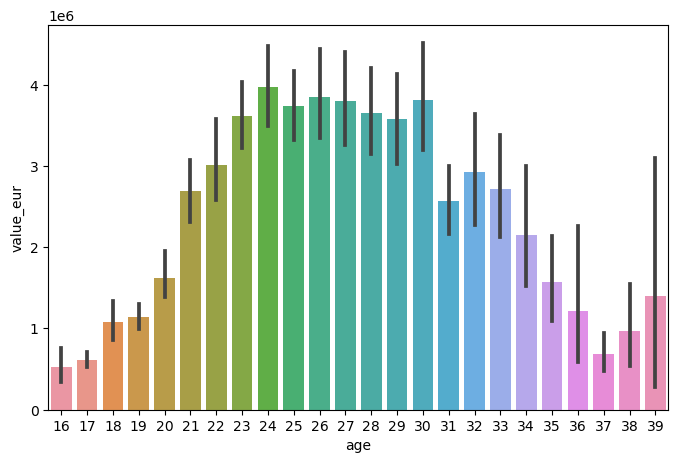

In [35]:
#Create visual about age distribution and how it correlates to salary.
fig, axes = plt.subplots(figsize=(8,5))
sns.barplot(data=df, x='age', y='value_eur');

The players who earn the most money are between 23-30 years old.  After 31, the salaries drop off significantly. Young players with potential see their value rise significantly around 21 years old. 

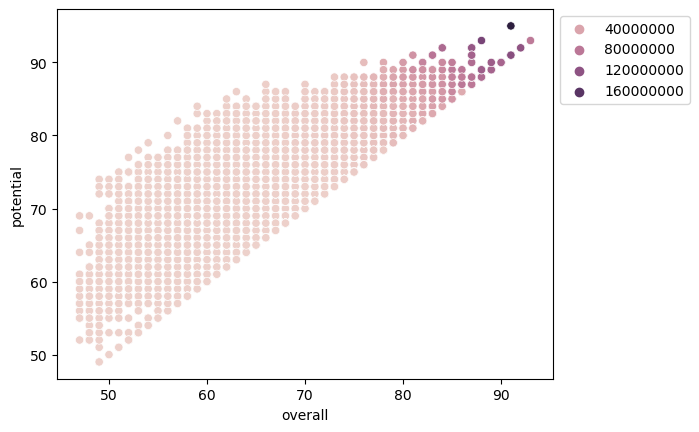

In [36]:
#Compare overall, potential, with salary
ax=sns.scatterplot(data=df, x='overall', y='potential', hue='value_eur')
ax.legend(bbox_to_anchor = (1,1));

Based on this scatter plot, we can deduce that clubs do not pay players for their "potential" (ie., young and upcoming superstars who haven't yet proven themselves). Unlike some American sports, like NFL and NBA, European footballers need to prove themselves and cannot rely on clubs to take a flier on them simply based off of promise. 

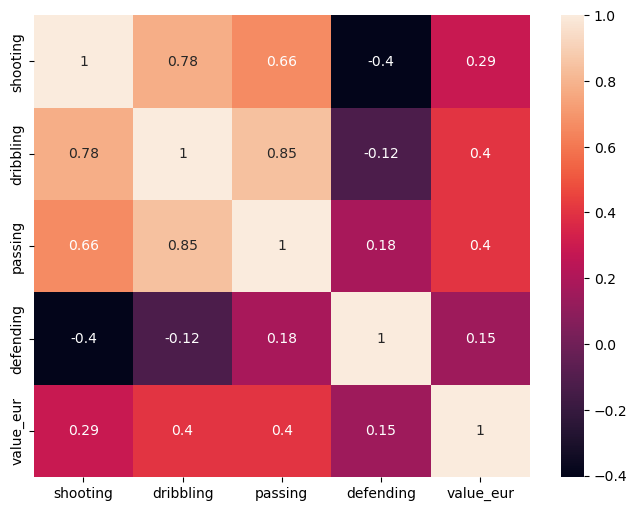

In [37]:
#Creat heatmap to see correlation between shooting, dribbling, passing, and defending to see if one is
#valued more than the other
cols_to_use1 = ['shooting', 'dribbling', 'passing', 'defending', 'value_eur']
heat_df = df[cols_to_use1]

fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(heat_df.corr(), annot=True, ax=ax);

Out of all of the top metrics used to describe a player, defending has the lowest correlation to amount of euros earned. Players with high passing and dribbling skills have a higher chance to earn more euros. 

Interestingly, players with high shooting ratings (ideally - your best shot takers) - have a fairly low correlation to high earnings.

Key Finding #1 - Age Matters

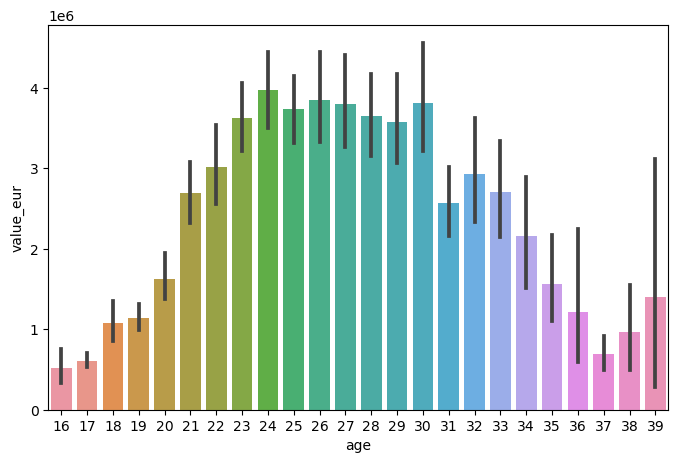

In [38]:
#Create visual about age distribution and how it correlates to salary.
fig, axes = plt.subplots(figsize=(8,5))
sns.barplot(data=df, x='age', y='value_eur');

This graph shows the age distribution related to how much each player earns. The top earners are between the ages of 24-30, with a steep drop off after 30 years old.  The youngest player in the data set is 16, and the oldest is 43.

#Key Finding #2 - You should practice your dribbling and passing skills 

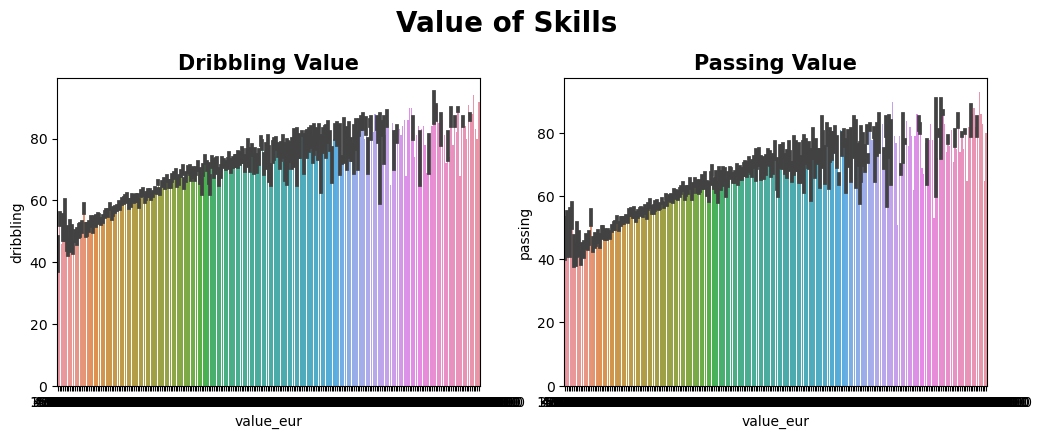

In [39]:

fig, axes = plt.subplots(ncols=2, figsize = (12,4))

sns.barplot(data=df, x='value_eur', y='dribbling', ax=axes[0])
axes[0].set_title('Dribbling Value', fontsize=15, fontweight = 'bold')

sns.barplot(data=df, x='value_eur', y='passing', ax=axes[1])
axes[1].set_title('Passing Value', fontsize=15, fontweight = 'bold')

fig.suptitle('Value of Skills', fontsize= 20, fontweight = 'bold', y=1.05);

There is a strong correlation between a player's dribbling skills, passing skills, and how much they earn. Moreso than other metrics, these are the top skills that clubs are looking for in players.

Prepare data for machine learning

In [40]:
#Split the data
y = df['value_eur']
X = df.drop(columns='value_eur')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Impute missing values

In [41]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output = False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')
constant_imputer = SimpleImputer(strategy = 'constant', fill_value='missing')


In [42]:
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(constant_imputer, ohe)


In [43]:
cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include = 'number')

num_tuple = (num_pipe, num_cols)
cat_tuple = (cat_pipe, cat_cols)

In [44]:
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='drop')

In [45]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7F40>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7520>)])

In [46]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [47]:
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed[:5]

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (12780, 66)




array([[-2.3512456 , -1.20023427, -1.53323715, -0.05935   , -0.6134862 ,
        -0.29732507, -0.37069458, -2.00837313, -1.39437621, -2.14768914,
         0.1759023 , -1.32874075, -0.97103559, -0.54448317, -0.02240626,
        -1.14050325, -0.56412164, -2.25509716, -1.88690197,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.30949435, -0.53522

Regression Modeling

Fit several differnt models onto your preprocessed data, tune the models with grid search, and choose the best model

In [48]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics for a model
def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model', ):
  ## Train
  mae = mean_absolute_error(y_train, pipe.predict(x_train))
  mse = mean_squared_error(y_train, pipe.predict(x_train))
  rmse = np.sqrt(mean_squared_error(y_train, pipe.predict(x_train)))
  r2 = r2_score(y_train, pipe.predict(x_train))
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  ## Test
  mae = mean_absolute_error(y_test, pipe.predict(x_test))
  mse = mean_squared_error(y_test, pipe.predict(x_test))
  rmse = np.sqrt(mean_squared_error(y_test, pipe.predict(x_test)))
  r2 = r2_score(y_test, pipe.predict(x_test))

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [49]:
#Linear Regression Model
linreg = LinearRegression()
linreg_pipe = make_pipeline(preprocessor, linreg)
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7F40>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7520>)])),
                ('linearregression', LinearRegression())])

In [50]:
linreg_train_scores = linreg_pipe.score(X_train, y_train)
linreg_test_scores = linreg_pipe.score(X_test, y_test)

print(f'Linear Regression Training score: {linreg_train_scores}')
print(f'Linear Regression Testing score: {linreg_test_scores}')


Linear Regression Training score: 0.5524074294244447
Linear Regression Testing score: 0.57586783247294


In [51]:
#Evaluate the Linear Regression model
model_metrics(linreg_pipe, X_train, y_train, X_test, y_test, model_name='linreg')

linreg Train Scores
MAE: 2,587,235.1906 
MSE: 25,552,787,025,242.9570 
RMSE: 5,054,976.4614 
R2: 0.5524

linreg Test Scores
MAE: 2,676,960.4281 
MSE: 28,378,769,096,241.7773 
RMSE: 5,327,172.7113 
R2: 0.5759



The scores on the linear regression model are significantly low. Instead of tuning, I'm going to try some other models.

Fit a Decision Tree Model

In [53]:
dec_tree = DecisionTreeRegressor(random_state=42)
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)

dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7F40>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7520>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [54]:
dectree_train_score = dec_tree_pipe.score(X_train, y_train)
dectree_test_score = dec_tree_pipe.score(X_test, y_test)

print(f'Decision Tree Training Score: {dectree_train_score}')
print(f'Decision Tree Testing Score: {dectree_test_score}')

Decision Tree Training Score: 1.0
Decision Tree Testing Score: 0.9168900735792956


In [55]:
model_metrics(dec_tree_pipe, X_train, y_train, X_test, y_test, model_name='dectree')

dectree Train Scores
MAE: 0.0000 
MSE: 0.0000 
RMSE: 0.0000 
R2: 1.0000

dectree Test Scores
MAE: 228,467.4959 
MSE: 5,560,901,983,102.5576 
RMSE: 2,358,156.4798 
R2: 0.9169



In [62]:
#Tune the decision tree
dec_tree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7F40>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                           

In [76]:
dec_tree_params = {'decisiontreeregressor__max_depth': range(1,10), 
                   'decisiontreeregressor__min_samples_leaf': range(6,11),
                   'decisiontreeregressor__min_weight_fraction_leaf': [.1,.2,.3,.4,.5]
                   }
dec_tree_gs = GridSearchCV(dec_tree_pipe, param_grid=dec_tree_params)

In [77]:
dec_tree_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7F40>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_valu...
                                                                                                        sparse_output=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7520>)])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': range(1, 10),
                         'decisiontreeregressor__min_samples_leaf': range(6, 11),
                         'decisiontreeregressor__min_weight_fraction_leaf': [0.1,
                                                                             0.2,
                                                                             0.3,
                                                                             0.4,
                                                                             0.5]})

In [78]:
print(dec_tree_gs.best_params_)

{'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 6, 'decisiontreeregressor__min_weight_fraction_leaf': 0.1}


In [81]:
best_dec_tree = dec_tree_gs.best_estimator_

In [82]:
best_dec_tree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE954CA00>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE954CFD0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=6,
                                       min_weight_fraction_leaf=0.1,
                                       random_state=42))])

In [83]:
model_metrics(best_dec_tree, X_train, y_train, X_test, y_test, model_name='Bestdectree')

Bestdectree Train Scores
MAE: 1,558,351.3066 
MSE: 32,416,678,409,683.1484 
RMSE: 5,693,564.6488 
R2: 0.4322

Bestdectree Test Scores
MAE: 1,677,460.2189 
MSE: 39,333,335,512,408.3828 
RMSE: 6,271,629.4145 
R2: 0.4121



The un-tuned Decision Tree Model worked better than the tuned decision tree model.

Fit Random Forest Model

In [67]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7F40>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7520>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [68]:
#Evaluate random forest model
rf_train_scores = rf_pipe.score(X_train, y_train)
rf_test_scores = rf_pipe.score(X_test, y_test)

print(f'RF Training Scores: {rf_train_scores}')
print(f'RF Testing Scores: {rf_test_scores}')

RF Training Scores: 0.9947386761258955
RF Testing Scores: 0.981334052189763


In [69]:
model_metrics(rf_pipe, X_train, y_train, X_test, y_test, model_name='RandomForest')

RandomForest Train Scores
MAE: 52,974.2175 
MSE: 300,365,772,946.0094 
RMSE: 548,056.3593 
R2: 0.9947

RandomForest Test Scores
MAE: 150,668.6576 
MSE: 1,248,942,342,566.8857 
RMSE: 1,117,560.8899 
R2: 0.9813



In [70]:
#Tune RF Model
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

28

In [74]:
rf_tuned = make_pipeline(preprocessor, RandomForestRegressor(n_estimators = 28, random_state=42))
rf_tuned.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7F40>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7520>)])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=28, random_state=42))])

In [75]:
model_metrics(rf_tuned, X_train, y_train, X_test, y_test, model_name='RandomForestTuned')

RandomForestTuned Train Scores
MAE: 55,826.5845 
MSE: 243,023,503,274.1089 
RMSE: 492,974.1406 
R2: 0.9957

RandomForestTuned Test Scores
MAE: 142,278.1373 
MSE: 1,100,459,080,219.7432 
RMSE: 1,049,027.6832 
R2: 0.9836



Bagged Tree Model

In [99]:
bag_treee = BaggingRegressor(random_state=42)
bag_tree_pipe = make_pipeline(preprocessor, bag_treee)
bag_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7F40>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7520>)])),
                ('baggingregressor', BaggingRegressor(random_state=42))])

In [100]:
model_metrics(bag_tree_pipe, X_train, y_train, X_test, y_test, model_name='BaggedTree')

BaggedTree Train Scores
MAE: 68,136.4241 
MSE: 421,032,498,298.1221 
RMSE: 648,870.1706 
R2: 0.9926

BaggedTree Test Scores
MAE: 171,526.4023 
MSE: 1,856,474,776,578.2681 
RMSE: 1,362,525.1471 
R2: 0.9723



In [118]:
bag_tree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7F40>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                           

In [123]:
bag_params = {'baggingregressor__n_jobs':[1,2,3,4,5], 'baggingregressor__random_state':[42],
'baggingregressor__verbose': [0,1,2]}
bag_tree_gs = GridSearchCV(bag_tree_pipe, param_grid=bag_params)

In [124]:
bag_tree_gs.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...
Building estimator 1 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...
Building estimator 1 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jo

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7F40>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_valu...
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000025EE27C7520>)])),
                                       ('baggingregressor',
                                        BaggingRegressor(random_state=42))]),
             param_grid={'baggingregressor__n_jobs': [1, 2, 3, 4, 5],
                         'baggingregressor__random_state': [42],
                         'baggingregressor__verbose': [0, 1, 2]})

In [125]:
bag_tree_gs.best_params_

{'baggingregressor__n_jobs': 1,
 'baggingregressor__random_state': 42,
 'baggingregressor__verbose': 0}

In [126]:
best_bag_tree = bag_tree_gs.best_estimator_

In [127]:
model_metrics(best_bag_tree, X_train, y_train, X_test, y_test, model_name='TunedBaggedTree')

TunedBaggedTree Train Scores
MAE: 68,136.4241 
MSE: 421,032,498,298.1221 
RMSE: 648,870.1706 
R2: 0.9926

TunedBaggedTree Test Scores
MAE: 171,526.4023 
MSE: 1,856,474,776,578.2681 
RMSE: 1,362,525.1471 
R2: 0.9723



Production Model

The best model was the tuned random forest (code below)

The mean average error - which predicts the difference between the actual and predicted values - shows about a $142K euro difference in salary predictions. Considering that average salary of all players in the data set is 2,965,082 euros ($3,259,959 US dollars), a difference of $142K is reasonable enough to predict.

The mean squared error - which just finds the squared difference of the MAE - isn't a valuable metric for this data set, considering that there are a high number of substitutes and reserve players who make significantly less than the positioned (full time) players.

The best metric to determine efficieny of the model is R2 - which determines how much variance can be explained by the data - in this case it is 98%.


In [141]:
model_metrics(rf_tuned, X_train, y_train, X_test, y_test, model_name='RandomForestTuned')

RandomForestTuned Train Scores
MAE: 55,816.1329 
MSE: 243,701,993,735.7278 
RMSE: 493,661.8212 
R2: 0.9957

RandomForestTuned Test Scores
MAE: 143,220.7396 
MSE: 1,101,576,004,423.1257 
RMSE: 1,049,559.9099 
R2: 0.9835

